TODO
- data augmentation?

# Flower Recognition

In [121]:
from os import listdir
from random import shuffle

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

##### Load and format the data

In [124]:
flower_filenames = listdir('flowers')

flower_categories = {
    'daisy':     0,
    'dandelion': 1,
    'rose':      2,
    'sunflower': 3,
    'tulip':     4
}

# Normal arrays in order to let us dynamically append
x, y = [], []

# Shuffle the filenames as that'll randomize the data and labels while still keeping their order
shuffle(flower_filenames)

for file_count, filename in enumerate(flower_filenames):
    if file_count % 500 == 0: print(f'Loading {file_count}/{len(flower_filenames)}')
    
    image = Image.open('flowers/' + filename)
    
    # Resize the images to 64x64 as they'll still contain plenty of information for our use case
    image = image.resize((64, 64))
    
    # Grab the ground truth label from the filename and convert it into the correct category
    flower_category = flower_categories[filename.split(' ')[0]]
    
    x.append(np.array(image))
    y.append(flower_category)
    

# Convert to numpy array, as we're done appending
x, y = np.array(x), np.array(y)

print(
    f'x shape: {np.shape(x)}\n'
    f'y shape: {np.shape(y)}'
)

Loading 0/4317


Loading 500/4317
Loading 1000/4317
Loading 1500/4317
Loading 2000/4317
Loading 2500/4317
Loading 3000/4317
Loading 3500/4317
Loading 4000/4317
x shape: (4317, 64, 64, 3)
y shape: (4317,)


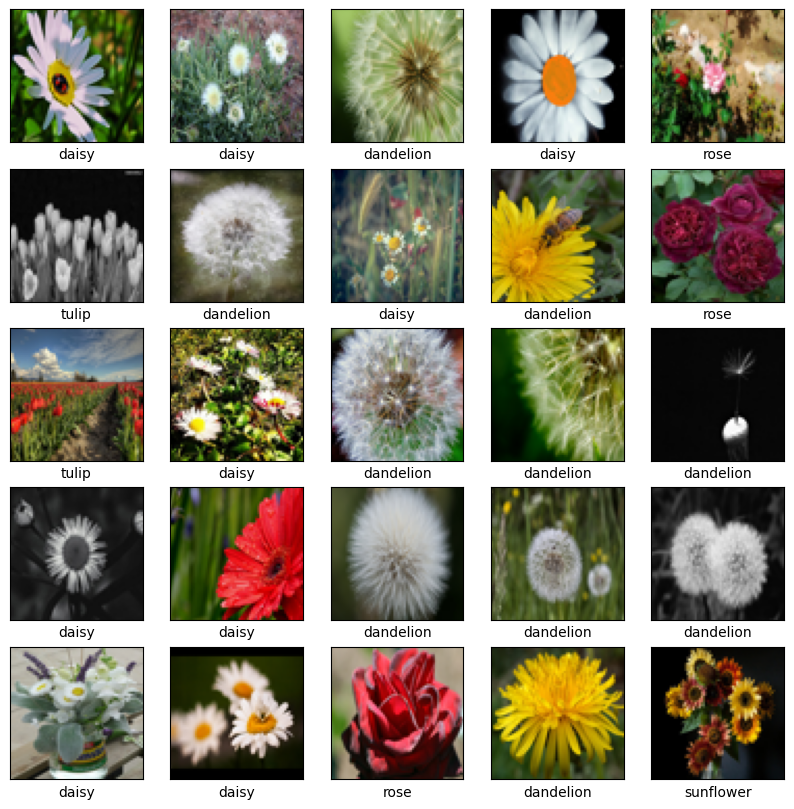

In [125]:
# Easier/cleaner than doing a reverse lookup using flower_names_scheme
flower_names = [
    'daisy',
    'dandelion',
    'rose',
    'sunflower',
    'tulip'
]

plt.figure(figsize=(10,10))

for i in range(25):
    # the subplots are added sequentially, even though the dimentions are specified explicitly
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    plt.xlabel(flower_names[y[i]])

plt.show()

##### Normalize the data

In [126]:
# Divide by max value to normalize
x = x / 255
print(f'x range: {x.min()} - {x.max()}')

x range: 0.0 - 1.0


##### Train test split

In [131]:
# This will technically shuffle the data once more. But hey, can't hurt right?
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(
    f'x_train shape: {np.shape(x_train)}\n'
    f'y_train shape: {np.shape(y_train)}\n'
    f'x_test shape: {np.shape(x_test)}\n'
    f'y_test shape: {np.shape(y_test)}'
)

x_train shape: (3453, 64, 64, 3)
y_train shape: (3453,)
x_test shape: (864, 64, 64, 3)
y_test shape: (864,)


##### Create and train model

In [163]:
# hyperparams
# filters
# strides
# dense units
# conv layers
# maxpooling layers
# dense layers
# regularization (early stopping, l1 and l2)


model = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    
    Flatten(),
    Dense(units=32, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=5, activation='softmax'),
])

# Using sparse_categorical_crossentropy instead of categorical_crossentropy as sparse allows us to use integer labels
# instead of needing some other encoding scheme
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [164]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
87/87 [==============================] - 33s 344ms/step - loss: 1.4873 - accuracy: 0.3266 - val_loss: 1.3565 - val_accuracy: 0.4038
Epoch 2/10
87/87 [==============================] - 29s 330ms/step - loss: 1.2588 - accuracy: 0.4692 - val_loss: 1.3429 - val_accuracy: 0.4240
Epoch 3/10
87/87 [==============================] - 29s 332ms/step - loss: 1.1166 - accuracy: 0.5489 - val_loss: 1.0947 - val_accuracy: 0.5514
Epoch 4/10
87/87 [==============================] - 29s 331ms/step - loss: 1.0156 - accuracy: 0.5974 - val_loss: 1.1063 - val_accuracy: 0.5543
Epoch 5/10
87/87 [==============================] - 29s 331ms/step - loss: 0.9500 - accuracy: 0.6365 - val_loss: 1.0183 - val_accuracy: 0.6035
Epoch 6/10
87/87 [==============================] - 28s 328ms/step - loss: 0.8958 - accuracy: 0.6542 - val_loss: 1.1157 - val_accuracy: 0.5977
Epoch 7/10
87/87 [==============================] - 29s 329ms/step - loss: 0.8298 - accuracy: 0.6807 - val_loss: 1.0728 - val_accuracy: 0.6064

In [165]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

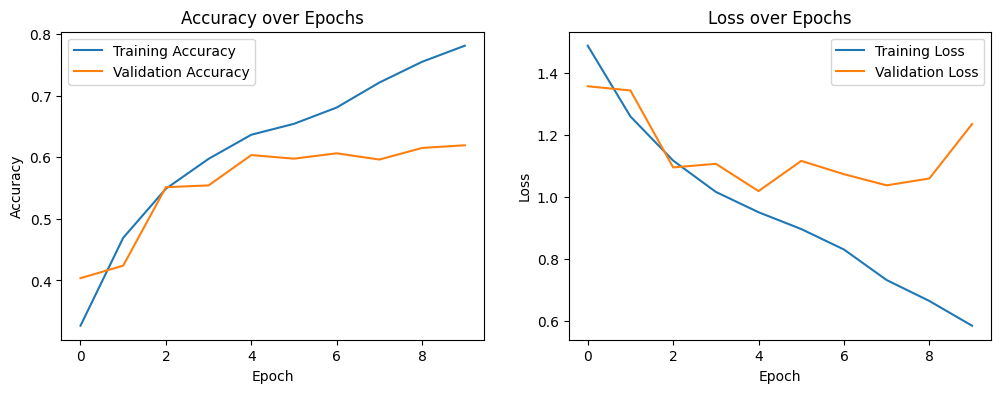

Accuracy: 65.0%
Loss: 1.12


In [166]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(
    f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
    f'Loss: {round(test_loss, 2)}'    
)

• Motivera din modellarkitektur och val av relevanta hyperparametrar.

• Vilka aktiveringsfunktioner har du använt? Varför?

• Vilken loss funktion har du använt? Varför?

• Har du använt någon databehandling? Varför?

• Har du använt någon regulariseringsteknik? Motivera.

• Hur har modellen utvärderats?

• Är prestandan bra? Varför/ varför inte?

• Vad hade du kunnat göra för att förbättra den ytterligare?